In [1]:
import numpy as np
import pandas as pd
from plotnine import *

In this notebook, we use linear interpolation to fill in missing values in the HARP data.

In [2]:
harp_data = pd.read_parquet("../harp_data/data/processed/hmi_sharp_cea_720s.parquet")
harp_data.head()

,HARPNUM,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,LON_FWT,LAT_FWTPOS,LON_FWTPOS,LAT_FWTNEG,LON_FWTNEG,T_FRST1,T_LAST1,NOAA_AR,NOAA_NUM,NOAA_ARS
0,1,2010-05-01 00:00:00+00:00,6.510776e+21,28.337,66.808,84.497,32.193,-0.131873,5.777592e+12,0.009330,...,-78.194817,23.822844,-78.326813,23.677998,-75.876213,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
1,1,2010-05-01 00:12:00+00:00,6.521054e+21,29.678,68.349,90.781,32.345,-0.113589,5.654726e+12,-0.004021,...,-78.183884,23.763060,-78.388466,23.785194,-75.429527,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
2,1,2010-05-01 00:24:00+00:00,6.917875e+21,28.441,67.682,89.127,32.411,0.061197,6.488687e+12,0.003400,...,-77.894882,23.770275,-78.056015,23.708254,-75.365669,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
3,1,2010-05-01 00:36:00+00:00,6.973706e+21,28.031,67.166,85.321,31.966,0.053302,6.193157e+12,0.005150,...,-77.822472,23.789299,-78.000526,23.625120,-75.309296,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
4,1,2010-05-01 00:48:00+00:00,7.228647e+21,26.980,64.805,76.349,32.647,0.011571,5.797055e+12,0.000902,...,-77.759651,23.775604,-77.954346,23.754055,-74.332764,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067


We will fill in missing values in the columns listed below.

In [3]:
all_predictors = [
    # SHARP parameters
    "USFLUX", "MEANGAM", "MEANGBT", "MEANGBZ", "MEANGBH", "MEANJZD", "TOTUSJZ", "MEANALP",
    "MEANJZH", "TOTUSJH", "ABSNJZH", "SAVNCPP", "MEANPOT", "TOTPOT", "MEANSHR", "SHRGT45",
    # Patch areas and pixel counts
    "NPIX", "SIZE", "AREA", "NACR", "SIZE_ACR", "AREA_ACR"
]

We use linear interpolation for each HARP.

In [4]:
no_na_harp_data = harp_data.copy()
no_na_harp_data[all_predictors] = harp_data.groupby("HARPNUM")[all_predictors].apply(lambda df: df.interpolate()).reset_index(drop=True)

We next separately number records for each HARP, e.g., the `m` records for the first HARP are numbered `0, ..., m - 1`, the `n` records for the second HARP are numbered `0, ..., n - 1`, etc. We also flag records for which at least one predictor still has a missing value. Because of how linear interpolation works, for each HARP, records that are still missing values should be in runs at the start or end.

In [5]:
no_na_harp_data["index_in_harp"] = no_na_harp_data.groupby("HARPNUM").cumcount()
no_na_harp_data["are_any_predictors_na"] = no_na_harp_data[all_predictors].isna().any(axis=1)

The code below verifies that records with missing values are in runs at the start or end. If a record with missing values were in the middle, then the indices of some two complete records would differ by more than one.

In [6]:
(
    no_na_harp_data
    .groupby("HARPNUM")[["index_in_harp", "are_any_predictors_na"]]
    .apply(lambda df: (df.loc[~df["are_any_predictors_na"], "index_in_harp"].diff() > 1).any())
    .any()
)

False

For the sake of simplicity, we discard records that still have missing values. We also drop columns that are no longer needed.

In [7]:
no_na_harp_data = no_na_harp_data[~no_na_harp_data["are_any_predictors_na"]].drop(columns=["index_in_harp", "are_any_predictors_na"])

We count records by HARP using both the original data and the new data.

In [8]:
orig_rec_counts = harp_data.groupby("HARPNUM").size()
new_rec_counts = no_na_harp_data.groupby("HARPNUM").size()
all_rec_counts = pd.DataFrame({"orig_rec_count": orig_rec_counts, "new_rec_count": new_rec_counts}).reset_index()
all_rec_counts["new_rec_count"] = all_rec_counts["new_rec_count"].replace(np.nan, 0).astype("int")

Several HARPs no longer have any records in the data.

In [9]:
all_rec_counts[all_rec_counts["new_rec_count"] == 0]

,HARPNUM,orig_rec_count,new_rec_count
418,731,12,0
472,807,15,0
502,870,18,0
638,1144,22,0
1152,2080,6,0
1154,2083,22,0
2287,4149,5,0
2718,4972,10,0
3340,6090,16,0
3713,6713,1,0


We compute the absolute and relative changes in the record counts for HARPs that still have records.

In [10]:
all_rec_counts = all_rec_counts[all_rec_counts["new_rec_count"] > 0]
all_rec_counts["diff"] = all_rec_counts["orig_rec_count"] - all_rec_counts["new_rec_count"]
all_rec_counts["rel_diff"] = all_rec_counts["diff"] / all_rec_counts["orig_rec_count"]

Below is a histogram of the relative differences; for the vast majority of HARPs, the relative difference is close to zero.

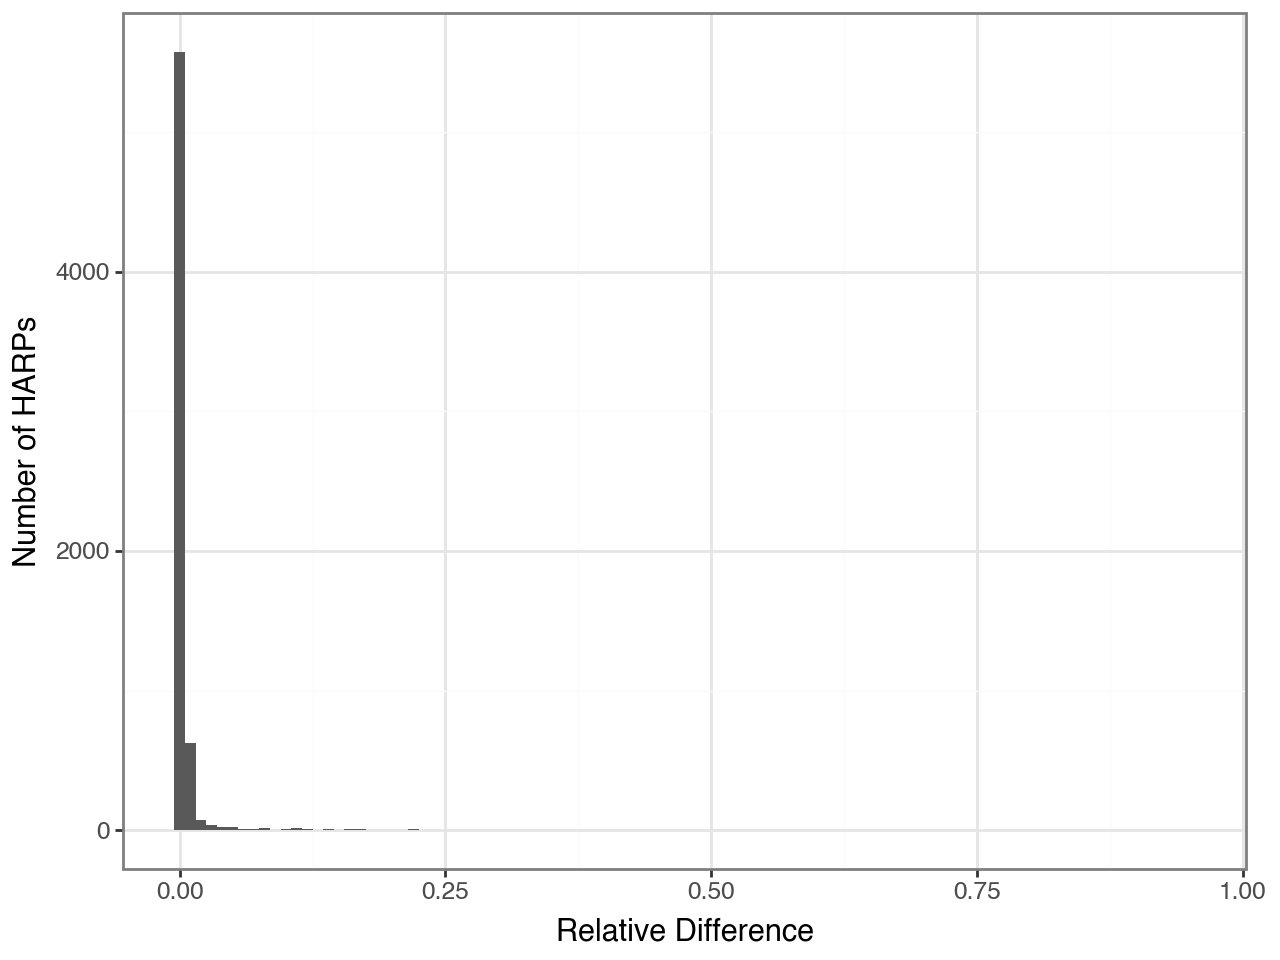

In [11]:
(
    ggplot(data=all_rec_counts, mapping=aes(x="rel_diff")) +
    geom_histogram(binwidth=0.01) +
    labs(x="Relative Difference", y="Number of HARPs") +
    theme_bw()
)

Below are the HARPs with the largest relative differences.

In [12]:
all_rec_counts.sort_values(["rel_diff", "orig_rec_count"], ascending=False).head(10)


,HARPNUM,orig_rec_count,new_rec_count,diff,rel_diff
831,1486,38,2,36,0.947368
2687,4892,3,1,2,0.666667
3546,6443,44,16,28,0.636364
2370,4292,25,11,14,0.560000
1404,2496,240,120,120,0.500000
1061,1933,118,59,59,0.500000
1393,2474,255,135,120,0.470588
3844,6935,17,9,8,0.470588
1391,2472,258,138,120,0.465116
5252,9173,31,17,14,0.451613


Save the imputed data.

In [13]:
no_na_harp_data.to_parquet("../harp_data/data/processed/no_na_hmi_sharp_cea_720s.parquet")